In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

import os
from glob import glob
import random
import sklearn
import scipy.stats as stats
import scipy.special as sps

print(f'tensorflow version: {tf.__version__}')
print(f'opencv version:     {cv2.__version__}')

tensorflow version: 2.5.0
opencv version:     4.5.2


## NEON Still-frame Convolutional Autoencoder
---

In this notebook, we will compile and train a convolutional autoencoder which we will use to detect anomalies in still-frame images.

Our hypothesis is that the autoencoder's reconstruction loss of a still-frame image will be higher for anomalous images than for normal images.

### Dataset

The dataset used in this notebook is taken from the NEON phenocam data repository. You can browse the data repository via NEON's Data Portal at [https://data.neonscience.org/](https://data.neonscience.org/).

A useful tool for downloading and formatting the data directory can be found at: [https://github.com/waggle-sensor/ml-neon-snow](https://github.com/waggle-sensor/ml-neon-snow).

In [2]:
from tensorflow.keras.utils import Sequence

class NEONDatasetBatcher(Sequence):
    """
        This class loads NEON images in batches
    """
    
    def __init__(self, image_paths, batch_size, image_shape):
        
        assert(image_shape[0] > 0)
        assert(image_shape[1] > 0)
        assert(image_shape[2] == 3)
        self.image_shape = image_shape
        self.image_paths = image_paths
        self.batch_size = batch_size


        
    def __len__(self):
        return (np.ceil(len(self.image_paths) / float(self.batch_size))).astype(np.int)
    
    def full_batch_len(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_images = []
        for path in batch_paths:
            im = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (self.image_shape[0],self.image_shape[1]))
            batch_images.append(im)
            batch_np = (np.array(batch_images) / 255.)
        return batch_np, batch_np
    
class NEONDataset():
    """
        This class loads a NEON dataset. The directory structure is:
         <path>
            |--- normal
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <image0.jpg>
            |      |       |      |     | --- <image1.jpg>
            |     ...     ...    ...   ...
            |
            |--- anomalies
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <imageA.jpg>
            |      |       |      |     | --- <imageB.jpg>
            |     ...     ...    ...   ...
    """
    
    def __init__(self, path):
        assert(os.path.isdir(path))
        self.path = path
        self.normal_site_data = {}
        self.anomalies_site_data = {}
        subdirs = os.listdir(path)
        assert('normal' in subdirs)
        assert('anomalies' in subdirs)
        normal_path = os.path.join(path, 'normal')
        anomalies_path = os.path.join(path, 'anomalies')
        
        # parse normal data:
        self.sites = list(set(os.listdir(normal_path)) | set(os.listdir(anomalies_path)))
        for site_name in self.sites:
            site_path = os.path.join(normal_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.normal_site_data[site_name] = site_images
            
        # parse anomalous site data:
        for site_name in self.sites:
            site_path = os.path.join(anomalies_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.anomalies_site_data[site_name] = site_images

    def load_img(self, img_path):
        img = cv2.imread(img_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def get_normal_batchers(self, site_name, image_shape=(1280, 960, 3), 
                            batch_size=8, test_holdout=0.2, shuffle=True):
        image_paths = self.normal_site_data[site_name].copy()
        if shuffle:
            random.shuffle(image_paths)
        holdout_ind = int(test_holdout*len(image_paths))
        test_images = image_paths[:holdout_ind]
        train_images = image_paths[holdout_ind:]
        test_batcher = NEONDatasetBatcher(test_images, batch_size, image_shape)
        train_batcher = NEONDatasetBatcher(train_images, batch_size, image_shape)
        return train_batcher, test_batcher
        
    def get_anomalies_batcher(self, site_name, image_shape=(1280, 960, 3), batch_size=1):
        return NEONDatasetBatcher(self.anomalies_site_data[site_name], batch_size, image_shape)
        
    

Examples from NEON.D10.RMNP.DP1.00033:
(there are 2011 normal images for this site).


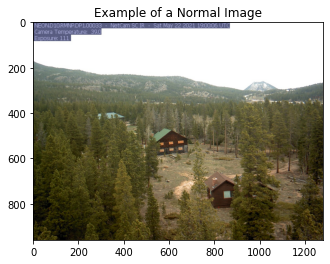

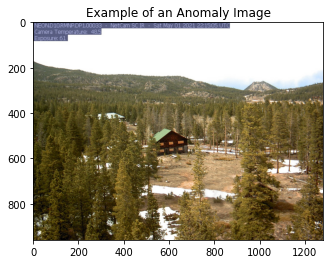

In [3]:
neon = NEONDataset('/datasets/neon')

site_of_interest = 'NEON.D10.RMNP.DP1.00033'
train_batcher, test_batcher = neon.get_normal_batchers(site_of_interest)
anomaly_batcher = neon.get_anomalies_batcher(site_of_interest)
example_normal_img = test_batcher.__getitem__(0)[0][0,...]
example_anomaly_img = anomaly_batcher.__getitem__(0)[0][0,...]

print(f'Examples from {site_of_interest}:')
print(f'(there are {len(neon.normal_site_data[site_of_interest])} normal images for this site).')
plt.imshow(example_normal_img)
plt.title('Example of a Normal Image')
plt.show()

plt.imshow(example_anomaly_img)
plt.title('Example of an Anomaly Image')
plt.show()

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.regularizers import l2

class NEON_CAE(Model):
    
    def __init__(self, latent_dim=64, input_shape=(960,1280,3)):
        super(NEON_CAE, self).__init__()
        self.latent_dim = latent_dim
        
        # encoder leaky ReLU
        lrelu = layers.LeakyReLU(alpha=0.1)
        
        # encoder regularizer
        reg = l2(5e-4)
        
        # Encoder Layers:
        self.encoder = tf.keras.Sequential([
            # apply 7x7 filter with maxpooling:
            layers.Conv2D(filters=16, kernel_size= (11, 11), 
                            strides=(2, 2), input_shape =input_shape, 
                            padding = 'same', activation=layers.LeakyReLU(alpha=0.1), 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3 filter with maxpooling:
            layers.Conv2D(filters=32, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3, 1x1 filter with maxpooling:
            layers.Conv2D(filters=48, kernel_size= (1, 1), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.Conv2D(filters=48, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3, 1x1 filter with maxpooling:
            layers.Conv2D(filters=64, kernel_size= (1, 1), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.Conv2D(filters=64, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # add latent layer:
            layers.Flatten(),
            layers.Dense(latent_dim)
        ],name='encoder')
        
        # Decoder Layers:
        
        last_conv_output_shape = tuple(x for x in self.encoder.layers[-2].input_shape if x != None )
        last_conv_output_size = np.prod(last_conv_output_shape)
        self.decoder = tf.keras.Sequential([
            # reshape back to last conv layer output:
            layers.Dense(last_conv_output_size, input_shape=(latent_dim,)),
            layers.Reshape(last_conv_output_shape),
            
            # apply upsampling, then transposed 1x1 and 2x2 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=64, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            layers.Conv2DTranspose(filters=64, kernel_size=(1,1),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 1x1 and 2x2 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=48, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            layers.Conv2DTranspose(filters=48, kernel_size=(1,1),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 3x3 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=32, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 11x11 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(11,11), strides=(2, 2),
                                      padding='same', activation=lrelu),
            layers.Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='sigmoid')
            
        ], name='decoder')
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

cae = NEON_CAE(latent_dim=64)
cae.encoder.summary()
cae.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 640, 16)      5824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 48)      1584      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 48)      20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 48)        0   

In [5]:
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
history = cae.fit(x=train_batcher,
          steps_per_epoch = train_batcher.full_batch_len(),
          epochs = 40,
          verbose = True,
          validation_data = test_batcher,
          validation_steps = test_batcher.full_batch_len())

Epoch 1/40
201/201 [==============================] - 121s 586ms/step - loss: 0.0630 - val_loss: 0.0257
Epoch 2/40
201/201 [==============================] - 117s 582ms/step - loss: 0.0182 - val_loss: 0.0143
Epoch 3/40
201/201 [==============================] - 117s 583ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 4/40
201/201 [==============================] - 118s 585ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 5/40
201/201 [==============================] - 118s 586ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 6/40
201/201 [==============================] - 118s 585ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 7/40
201/201 [==============================] - 118s 584ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 8/40
201/201 [==============================] - 118s 585ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 9/40
201/201 [==============================] - 118s 584ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 10/40
201/201 [==============================] - 118s 585m

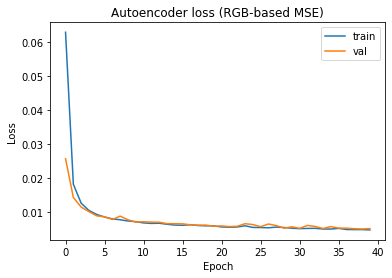

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder loss (RGB-based MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

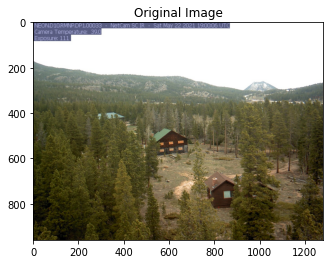

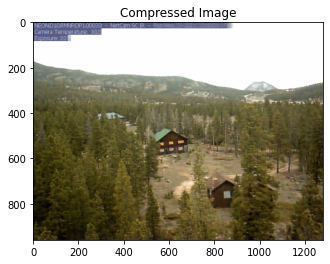

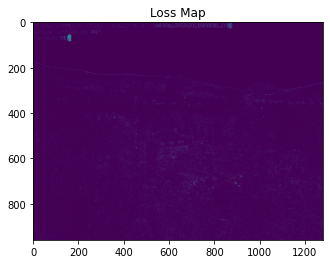

In [8]:
# plot validation example:
val_example = test_batcher.__getitem__(0)[0][0:1,...]

plt.figure()
plt.imshow(val_example[0])
plt.title('Original Image')
plt.show()

compressed_example = cae.predict(val_example)

plt.figure()
plt.imshow(compressed_example[0])
plt.title('Compressed Image')
plt.show()

lossmap = np.sum((val_example - compressed_example)**2, axis=3)
plt.figure()
plt.imshow(lossmap[0])
plt.title('Loss Map')
plt.show()




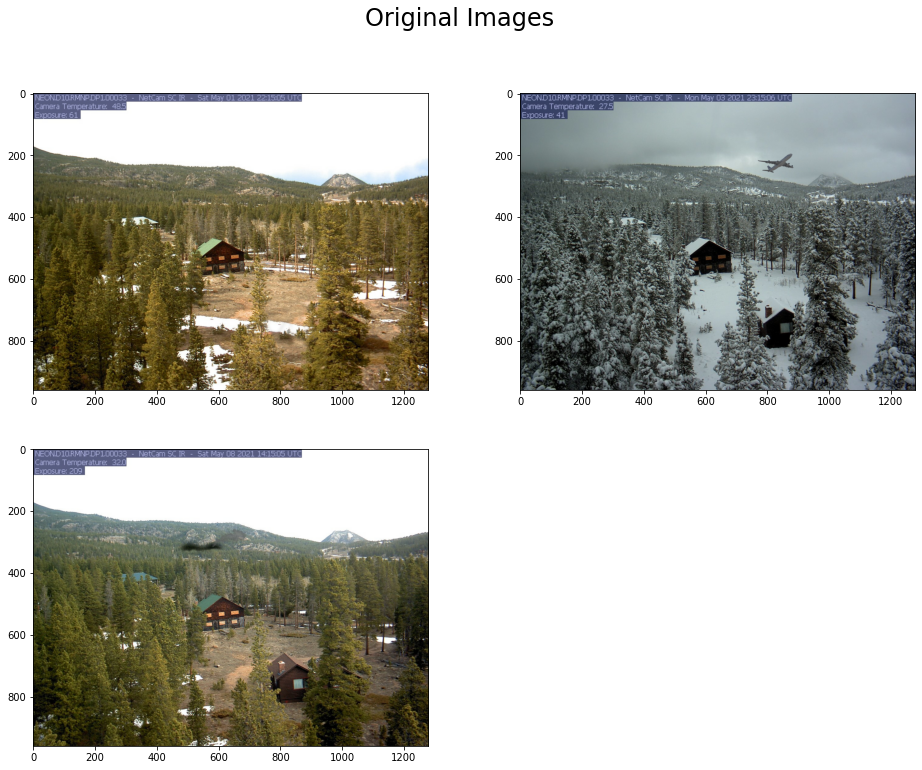

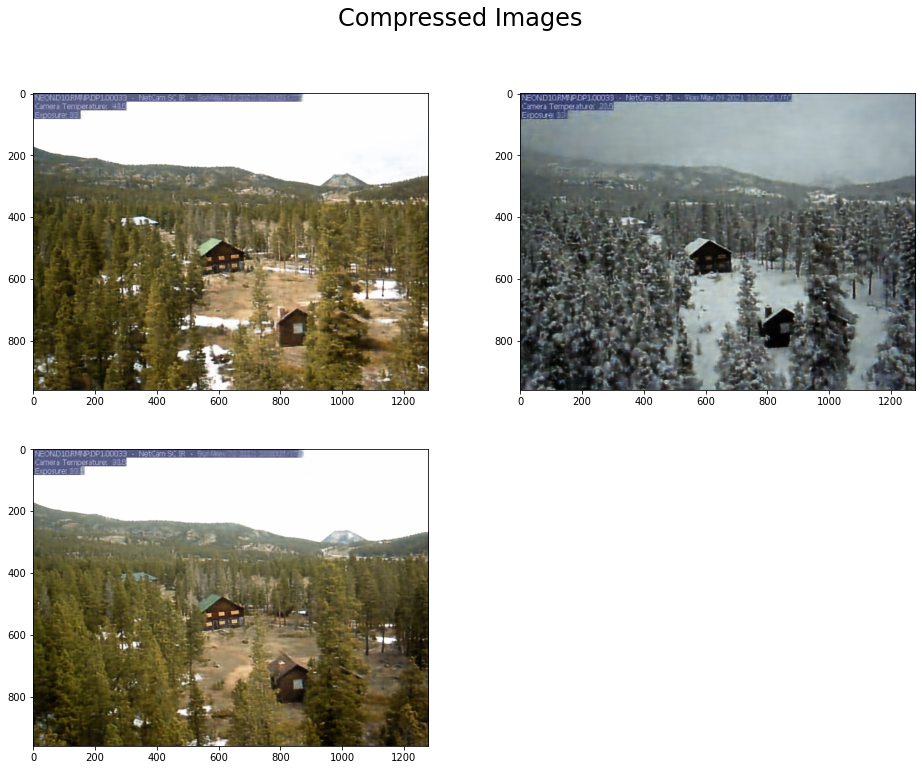

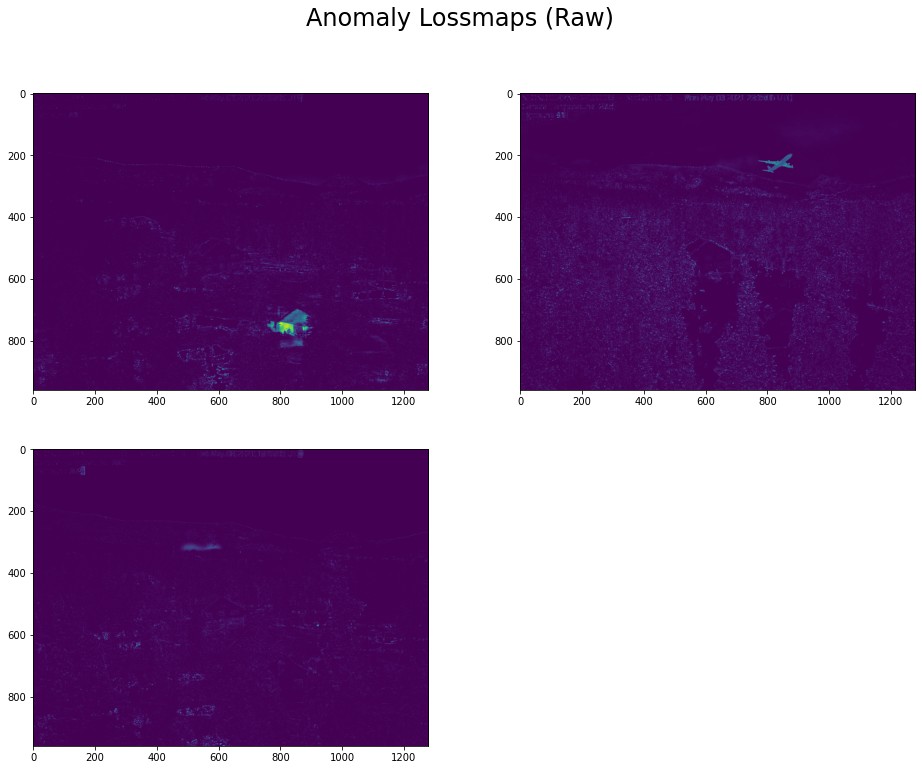

In [9]:
# plot anomaly example:
n_anomalies = len(anomaly_batcher)
anomaly_examples = [
    anomaly_batcher.__getitem__(i)[0][0:1,...]
    for i in range(n_anomalies)
]


fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, im in enumerate(anomaly_examples):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(im[0])
fig.suptitle('Original Images',fontsize=24)
#fig.tight_layout()
plt.show()

compressed_anomalies = [
    cae.predict(anomaly_batcher.__getitem__(i)[0])
    for i in range(n_anomalies)
]

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, im in enumerate(compressed_anomalies):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(im[0])
fig.suptitle('Compressed Images',fontsize=24)
#fig.tight_layout()
plt.show()

anomaly_lossmaps = [ 
    np.sum((x - y)**2, axis=3) 
    for x,y in zip(anomaly_examples, compressed_anomalies)
]

anomaly_loss = [ np.mean(lm) for lm in anomaly_lossmaps ]

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lm in enumerate(anomaly_lossmaps):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(lm[0])
fig.suptitle('Anomaly Lossmaps (Raw)',fontsize=24)
#fig.tight_layout()
plt.show()


In [10]:
# Compute loss for testing (validation) examples:
test_lossmaps = []
test_loss = []
for batch_ind in range(len(test_batcher)):
    batch = test_batcher.__getitem__(batch_ind)
    compressed_batch = cae.predict(batch[0])
    for im_x, im_y in zip(batch[0], compressed_batch):
        loss = np.sum((im_x - im_y)**2, axis=2)
        test_lossmaps.append(loss)
        test_loss.append(np.mean(loss))
        

Gamma(kappa=2.64, theta=0.01)
Mean: 0.01475
Std. Dev.: 0.009075


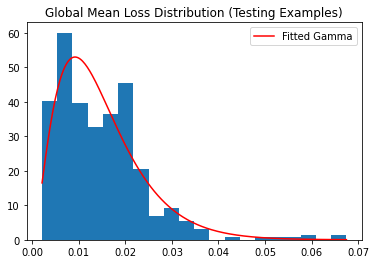

In [11]:
kappa, _, theta = stats.gamma.fit(test_loss, floc=0.)
print(f'Gamma(kappa={kappa:.2f}, theta={theta:.2f})')
gamma_x = np.linspace(np.min(test_loss), np.max(test_loss), 256)
gamma_y = stats.gamma.pdf(gamma_x,a=kappa,scale=theta)
gamma_mean = kappa*theta
gamma_std = np.sqrt(kappa*theta*theta)
print(f'Mean: {gamma_mean:.4}')
print(f'Std. Dev.: {gamma_std:.4}')

test_lossmaps = np.clip(np.array(test_lossmaps),1e-30,None)
test_loss = np.array(test_loss)

plt.figure()
plt.hist(test_loss, bins=20, density=True)
#plt.hist(anomaly_loss, bins=20, density=True)
plt.plot(gamma_x, gamma_y, 'r-', label='Fitted Gamma')
plt.title('Global Mean Loss Distribution (Testing Examples)')
plt.legend()
plt.show()


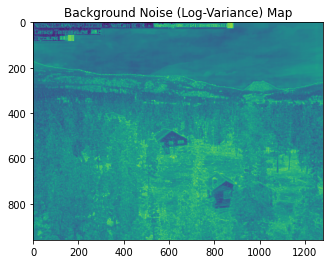

Average kappa: 0.43088244199680975
Average theta 0.03923592403940482


In [12]:
# compute distribution of background noise (by manually fitting to a gamma distribution):
log_lossmaps = np.log(test_lossmaps)
sum_x = np.sum(test_lossmaps, axis=0)
sum_logx = np.sum(log_lossmaps, axis=0)
sum_xlogx = np.sum(test_lossmaps*log_lossmaps, axis=0)
n = test_lossmaps.shape[0]

# use closed form estimators for kappa and theta:
kappa_hat = (n*sum_x) / (n*sum_xlogx - sum_x*sum_logx)
theta_hat = (n*sum_xlogx - sum_x*sum_logx) / (n*n)

variance_map = kappa_hat*theta_hat**2

plt.figure()
plt.imshow(np.log(variance_map))
plt.title('Background Noise (Log-Variance) Map')
plt.show()

print('Average kappa:', np.mean(kappa_hat))
print('Average theta', np.mean(theta_hat))


In [13]:
import matplotlib.patches as patches
import sklearn.preprocessing as preprocessing

def identify_lossmap_boxes(lossmap, kappa_hat, theta_hat, alpha=5e-5, 
                           min_area_frac=0.001, max_n_objs=5):
    im_size = lossmap.shape[0]*lossmap.shape[1]
    gamma_mass = stats.gamma.cdf(lossmap, a=kappa_hat, scale=theta_hat)
    _, thresh_lossmap = cv2.threshold(gamma_mass,(1.0-alpha),1.,cv2.THRESH_BINARY)
    thresh_lossmap = cv2.erode(thresh_lossmap, cv2.getStructuringElement(0, (5,5)))
    thresh_lossmap = cv2.dilate(thresh_lossmap, cv2.getStructuringElement(0, (11,11)))
    thresh_lossmap = thresh_lossmap.astype(np.uint8)

    cnts, _ = cv2.findContours(thresh_lossmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt_list = sorted([
        (cv2.boundingRect(c),cv2.contourArea(c))
        for c in cnts ],
        key= lambda x : -x[1])
    cnts = [ ca[0] for ca in cnt_list if ca[1] > min_area_frac*im_size ]
    cnts = cnts[:min(max_n_objs, len(cnts))]
    
    return thresh_lossmap, cnts

def show_boxes(boxes, ax_ind=0):
    for i, r in enumerate(boxes):
        rect = rect = patches.Rectangle((r[0], r[1]), r[2], r[3], linewidth=1, edgecolor='r', facecolor='none')
        plt.gcf().get_axes()[ax_ind].add_patch(rect)

lossmap_thresh_boxes = [
    identify_lossmap_boxes(lm[0], kappa_hat, theta_hat, max_n_objs=3)
    for lm in anomaly_lossmaps
]


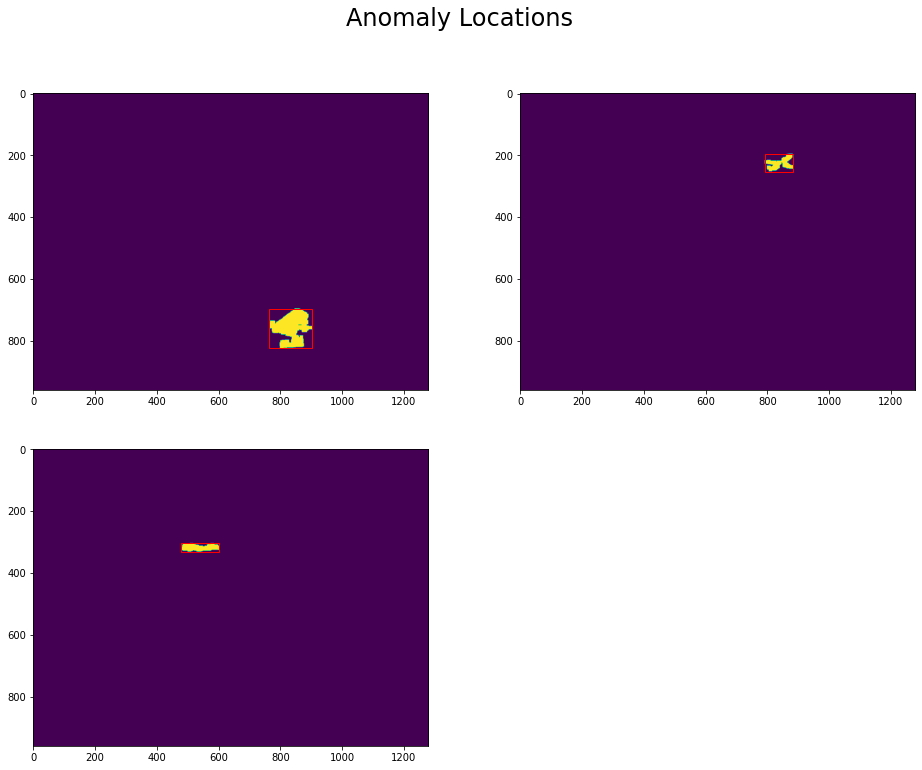

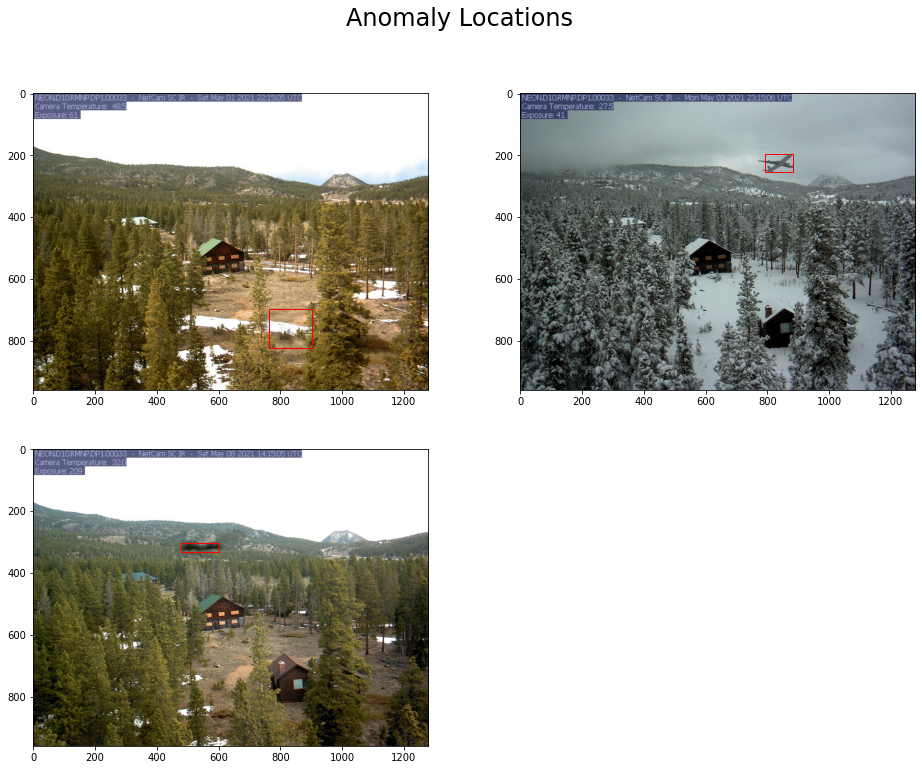

In [14]:
fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lmb in enumerate(lossmap_thresh_boxes):
    thresh, box = lmb
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(thresh)
    show_boxes(box, i)
    
fig.suptitle('Anomaly Locations',fontsize=24)
#fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lmb in enumerate(lossmap_thresh_boxes):
    _, box = lmb
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(anomaly_examples[i][0])
    show_boxes(box, i)
    
fig.suptitle('Anomaly Locations',fontsize=24)
#fig.tight_layout()
plt.show()

In [36]:
from multiprocessing import Pool
alpha_test_values = np.power(10,np.linspace(-8, -4, 12))
n_workers = 6
confusion_matrices = None

def compute_cm(alpha):
        cm = {'TP' : 0, 'FP' : 0, 'TN': 0, 'FN': 0}
        print(f'Computing confusion matrix for alpha={alpha:.3}...')
        for lm in test_lossmaps:
            _, boxes = identify_lossmap_boxes(lm, kappa_hat, theta_hat, alpha=alpha, max_n_objs=1)
            if len(boxes) > 0:
                cm['FP'] += 1
            else:
                cm['TN'] += 1
        for lm_bat in anomaly_lossmaps:
            l, boxes = identify_lossmap_boxes(lm_bat[0], kappa_hat, theta_hat, alpha=alpha, max_n_objs=1)
            if len(boxes) > 0:
                cm['TP'] +=1
            else:
                cm['FN'] += 1
        return cm

# compute confusion matrices:
with Pool(n_workers) as p:
    confusion_matrices = p.map(compute_cm, alpha_test_values)
    

Computing confusion matrix for alpha=1e-08...
Computing confusion matrix for alpha=1.23e-07...
Computing confusion matrix for alpha=5.34e-08...
Computing confusion matrix for alpha=2.31e-08...
Computing confusion matrix for alpha=2.85e-07...
Computing confusion matrix for alpha=6.58e-07...
Computing confusion matrix for alpha=1.52e-06...
Computing confusion matrix for alpha=3.51e-06...
Computing confusion matrix for alpha=8.11e-06...
Computing confusion matrix for alpha=1.87e-05...
Computing confusion matrix for alpha=4.33e-05...
Computing confusion matrix for alpha=0.0001...


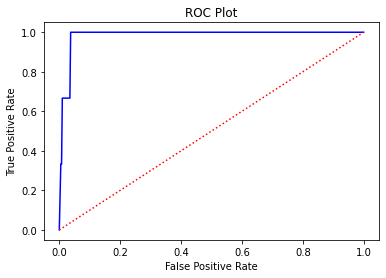

Area under ROC: 0.9842454394693201


In [39]:
def plot_operator_curve(y_func, x_func, cms, 
                        y_name='Y', x_name='X', title='Operator Curve'):
    pts = [ (x_func(cm),y_func(cm)) for cm in cms ]
    pts = np.array([(0,0)] + sorted(pts, key=lambda p : p[0]) + [(1,1)])
    plt.figure()
    plt.title(title)
    plt.plot(pts[:,0],pts[:,1], 'b')
    plt.plot([0,1],[0,1], 'r:')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot()
    plt.show()
    
    auc = np.trapz(y=pts[:,1],x=pts[:,0])
    return auc

TPR = lambda cm : cm['TP'] / (cm['TP'] + cm['FN'])
FPR = lambda cm : cm['FP'] / (cm['TN'] + cm['FP'])

auc = plot_operator_curve(TPR,FPR,confusion_matrices,
                          y_name='True Positive Rate',
                          x_name='False Positive Rate',
                          title='ROC Plot')
print(f'Area under ROC: {auc}')


In [40]:
# save the model:
save_path = cae.save(f'./models/CAE_{site_of_interest}')

INFO:tensorflow:Assets written to: ./models/CAE_NEON.D10.RMNP.DP1.00033/assets


INFO:tensorflow:Assets written to: ./models/CAE_NEON.D10.RMNP.DP1.00033/assets
